# Phase 2: Lifecycle Dynamic Asset Allocation via Finite-Horizon DP

**CME 241 – Reinforcement Learning for Stochastic Control Problems in Finance**

This notebook solves a simplified 3-asset (stocks, bonds, cash) portfolio + consumption
problem over a 25-period horizon using backward induction on a discrete MDP.

**Outline**
1. Model parameters & state/action spaces
2. Transition dynamics (income, regime, returns, wealth)
3. Backward-induction DP solver
4. Baseline strategies (static 60/40, linear glidepath)
5. Monte-Carlo simulation & comparison
6. Dimensionality analysis → motivation for RL in Phase 3



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
import warnings, time

warnings.filterwarnings("ignore", "divide by zero")
np.random.seed(42)
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "font.size": 11,
})

## 1. Model Parameters & Spaces

In [2]:
# Horizon
T = 25

# Wealth grid
N_WEALTH = 121
W_MIN, W_MAX = 0.0, 600.0
WEALTH_GRID = np.linspace(W_MIN, W_MAX, N_WEALTH)  # index 0..120

# Income states  Y ∈ {0 = low, 1 = high}
N_INCOME = 2
INCOME_VALS = np.array([5.0, 20.0])
INCOME_TRANS = np.array([
    [0.8, 0.2],   # from low
    [0.3, 0.7],   # from high
])

# Regime states  Z ∈ {0 = bear, 1 = bull}
N_REGIME = 2
REGIME_TRANS = np.array([
    [0.6, 0.4],   # from bear
    [0.3, 0.7],   # from bull
])

# Asset return scenarios per regime (stocks, bonds, cash)
# 3 scenarios per regime, each with a probability and a 3-vector of gross returns
RETURN_SCENARIOS = {
    0: {  # bear regime
        "probs": np.array([0.3, 0.5, 0.2]),
        "returns": np.array([
            [0.88, 1.02, 1.005],   # bad
            [0.97, 1.04, 1.005],   # medium
            [1.06, 1.06, 1.005],   # good
        ]),
    },
    1: {  # bull regime
        "probs": np.array([0.2, 0.5, 0.3]),
        "returns": np.array([
            [0.95, 1.01, 1.005],   # bad
            [1.08, 1.03, 1.005],   # medium
            [1.20, 1.05, 1.005],   # good
        ]),
    },
}
N_RETURN_SCENARIOS = 3

# Actions
CONS_FRACTIONS = np.array([0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20])
N_CONS = len(CONS_FRACTIONS)

# 15 discrete 3-asset allocations: weights in multiples of 0.25 summing to 1
ALLOC_LIST = []
for s in range(5):          # stocks weight  0.00 .. 1.00 step 0.25
    for b in range(5 - s):  # bonds weight   0.00 .. (1-s) step 0.25
        c = 4 - s - b       # cash  = remainder
        ALLOC_LIST.append(np.array([s, b, c]) * 0.25)
ALLOC_ARRAY = np.array(ALLOC_LIST)   # shape (15, 3)
N_ALLOC = len(ALLOC_ARRAY)
assert N_ALLOC == 15

N_ACTIONS = N_CONS * N_ALLOC  # 75

# Preferences
GAMMA = 2.0   # CRRA risk-aversion
BETA  = 0.96  # discount factor

print(f"Horizon T          = {T}")
print(f"Wealth grid points = {N_WEALTH}")
print(f"Income states      = {N_INCOME}")
print(f"Regime states      = {N_REGIME}")
print(f"Allocations        = {N_ALLOC}")
print(f"Consumption choices= {N_CONS}")
print(f"Total actions/state= {N_ACTIONS}")
print(f"States per period  = {N_WEALTH * N_INCOME * N_REGIME}")
print(f"Total state-time   = {T * N_WEALTH * N_INCOME * N_REGIME}")

Horizon T          = 25
Wealth grid points = 121
Income states      = 2
Regime states      = 2
Allocations        = 15
Consumption choices= 11
Total actions/state= 165
States per period  = 484
Total state-time   = 12100


## 2. Utility & Helper Functions

In [3]:
def crra_utility(c, gamma=GAMMA):
    """CRRA utility; returns -inf for c <= 0 to block infeasible consumption."""
    if gamma == 1.0:
        return np.where(c > 1e-12, np.log(c), -1e18)
    return np.where(c > 1e-12, c ** (1.0 - gamma) / (1.0 - gamma), -1e18)


def nearest_wealth_idx(w):
    """Snap a continuous wealth value to the nearest grid index."""
    idx = np.searchsorted(WEALTH_GRID, w, side="left")
    idx = np.clip(idx, 0, N_WEALTH - 1)
    # compare left and right neighbours
    left = np.clip(idx - 1, 0, N_WEALTH - 1)
    dist_left  = np.abs(w - WEALTH_GRID[left])
    dist_right = np.abs(w - WEALTH_GRID[idx])
    return np.where(dist_left < dist_right, left, idx)

## 3. Backward-Induction DP Solver

For each time step $t$ from $T{-}1$ down to $0$:

$$V_t(w, y, z) = \max_{(\alpha,\, \mathbf{w})} \left[ u(c) + \beta \sum_{y'}\sum_{z'}\sum_{k} p_{y'|y}\, p_{z'|z}\, p_k^{(z)} \; V_{t+1}(w', y', z') \right]$$

where $c = \alpha \cdot W$, and $w' = (W - c) \cdot (\mathbf{w} \cdot \mathbf{R}_k) + \text{income}(y')$.

In [4]:
# Value function:  V[t, w_idx, y, z]
# Policy:          policy_cons[t, w_idx, y, z]  -> index into CONS_FRACTIONS
#                  policy_alloc[t, w_idx, y, z] -> index into ALLOC_ARRAY

V = np.full((T + 1, N_WEALTH, N_INCOME, N_REGIME), -1e18)
policy_cons  = np.zeros((T, N_WEALTH, N_INCOME, N_REGIME), dtype=np.int32)
policy_alloc = np.zeros((T, N_WEALTH, N_INCOME, N_REGIME), dtype=np.int32)

# Terminal value: V_T = u(W)
V[T, :, :, :] = crra_utility(WEALTH_GRID, GAMMA)[:, None, None]

# Precompute portfolio gross returns: port_ret[alloc, regime, scenario]
ret_bear = RETURN_SCENARIOS[0]["returns"]   # (3, 3)
ret_bull = RETURN_SCENARIOS[1]["returns"]   # (3, 3)
port_returns = np.stack([
    ALLOC_ARRAY @ ret_bear.T,               # (15, 3)  bear
    ALLOC_ARRAY @ ret_bull.T,               # (15, 3)  bull
], axis=1)                                   # (15, 2, 3)

# Precompute immediate utility for each (wi, ci)
consumption = WEALTH_GRID[:, None] * CONS_FRACTIONS[None, :]   # (121, 5)
u_immediate = crra_utility(consumption, GAMMA)                 # (121, 5)
# u(0) stays at -1e18 from crra_utility, enforcing positive consumption

savings = WEALTH_GRID[:, None] - consumption                   # (121, 5)

print("Starting backward induction (vectorised) …")
t0 = time.time()

for t in range(T - 1, -1, -1):
    V_next = V[t + 1]   # (N_WEALTH, N_INCOME, N_REGIME)

    for yi in range(N_INCOME):
        py = INCOME_TRANS[yi]       # (2,)
        for zi in range(N_REGIME):
            pz  = REGIME_TRANS[zi]  # (2,)
            p_k = RETURN_SCENARIOS[zi]["probs"]  # (3,)

            # w_next[wi, ci, ai, k, yp] = savings[wi,ci] * port_ret[ai,zi,k] + income[yp]
            w_next = (savings[:, :, None, None, None]
                      * port_returns[None, None, :, zi, :][:, :, :, :, None]
                      + INCOME_VALS[None, None, None, None, :])
            w_next = np.clip(w_next, W_MIN, W_MAX)

            # Expected value via linear interpolation on the wealth grid
            EV = np.zeros((N_WEALTH, N_CONS, N_ALLOC))
            for yp in range(N_INCOME):
                for zp in range(N_REGIME):
                    p_yz = py[yp] * pz[zp]
                    w_vals = w_next[:, :, :, :, yp]
                    w_flat = np.clip(w_vals.ravel(), WEALTH_GRID[0], WEALTH_GRID[-1])
                    idx = np.searchsorted(WEALTH_GRID, w_flat) - 1
                    idx = np.clip(idx, 0, N_WEALTH - 2)
                    frac = (w_flat - WEALTH_GRID[idx]) / (WEALTH_GRID[idx + 1] - WEALTH_GRID[idx])
                    v_interp = ((1 - frac) * V_next[idx, yp, zp]
                                + frac * V_next[idx + 1, yp, zp]).reshape(w_vals.shape)
                    EV += p_yz * np.sum(p_k[None, None, None, :] * v_interp, axis=3)

            total = u_immediate[:, :, None] + BETA * EV    # (Nw, Nc, Na)

            # Best action per wealth level
            total_flat = total.reshape(N_WEALTH, -1)
            best = np.argmax(total_flat, axis=1)
            V[t, :, yi, zi] = total_flat[np.arange(N_WEALTH), best]
            policy_cons[t, :, yi, zi]  = best // N_ALLOC
            policy_alloc[t, :, yi, zi] = best %  N_ALLOC

    if (T - 1 - t) % 5 == 0:
        print(f"  t={t:>2d}  done  ({time.time()-t0:.1f}s)")

elapsed = time.time() - t0
print(f"DP completed in {elapsed:.1f}s")

Starting backward induction (vectorised) …
  t=24  done  (0.0s)
  t=19  done  (0.1s)
  t=14  done  (0.2s)
  t= 9  done  (0.3s)
  t= 4  done  (0.4s)
DP completed in 0.4s


## 4. Visualise Optimal Policy & Value Function

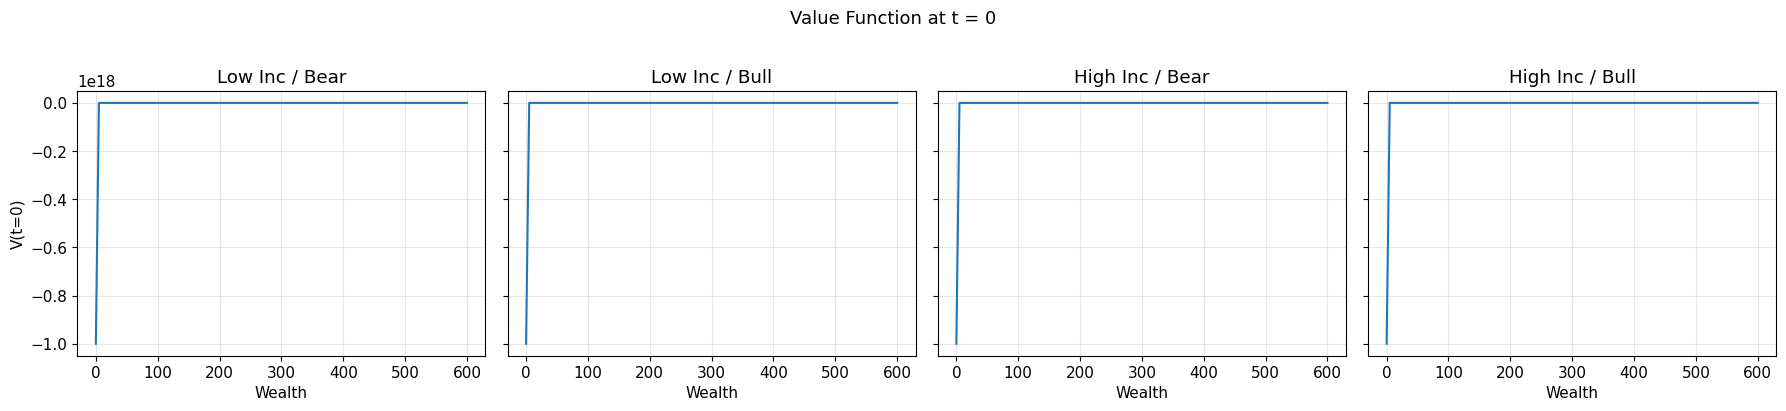

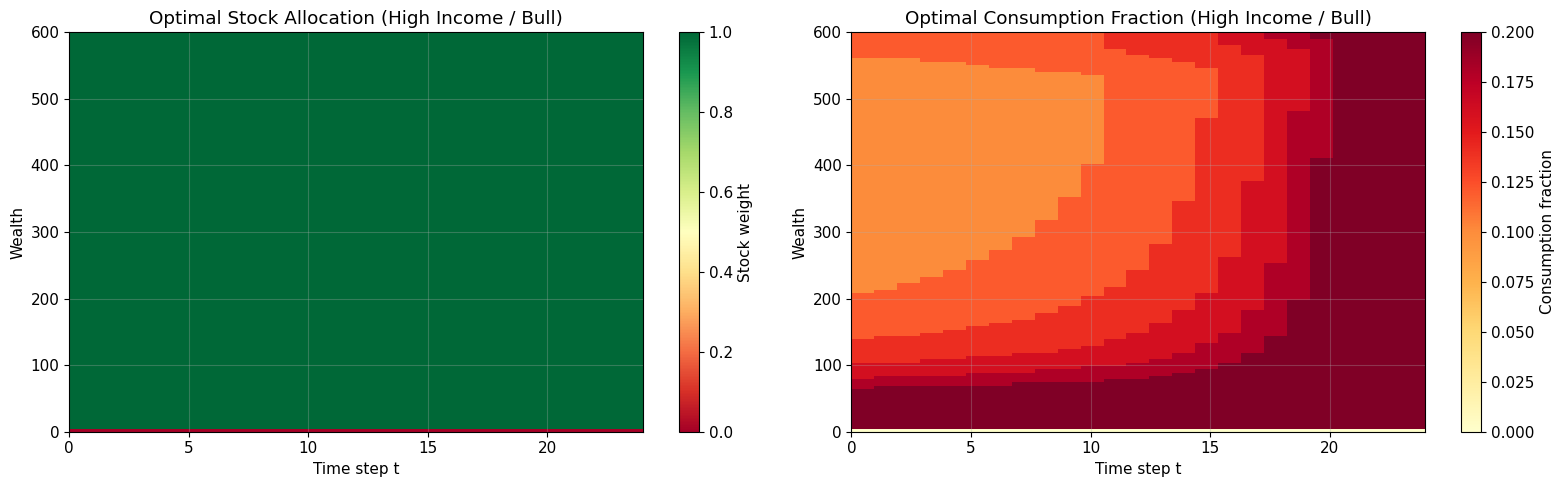

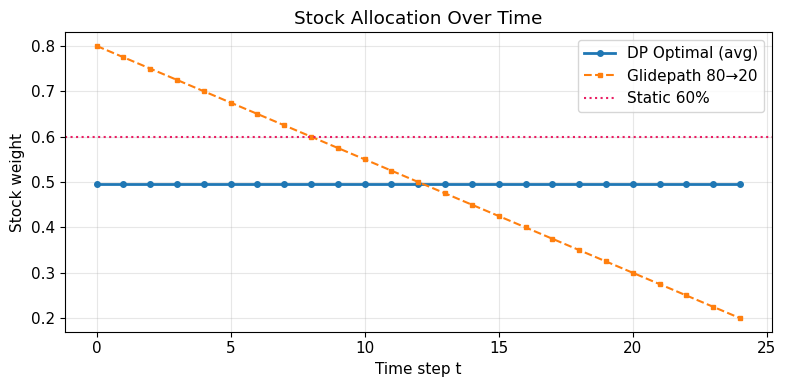

In [5]:
# Value function at t=0 for each (income, regime) pair
fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=True)
labels = [("Low Inc / Bear", 0, 0), ("Low Inc / Bull", 0, 1),
          ("High Inc / Bear", 1, 0), ("High Inc / Bull", 1, 1)]

for ax, (label, yi, zi) in zip(axes, labels):
    ax.plot(WEALTH_GRID, V[0, :, yi, zi])
    ax.set_title(label)
    ax.set_xlabel("Wealth")
axes[0].set_ylabel("V(t=0)")
fig.suptitle("Value Function at t = 0", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Policy heatmaps: stock allocation + consumption fraction (High Income / Bull)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

stock_map = ALLOC_ARRAY[policy_alloc[:, :, 1, 1], 0].T
im1 = axes[0].imshow(stock_map, aspect="auto", origin="lower",
                      extent=[0, T - 1, W_MIN, W_MAX], cmap="RdYlGn", vmin=0, vmax=1)
axes[0].set_xlabel("Time step t")
axes[0].set_ylabel("Wealth")
axes[0].set_title("Optimal Stock Allocation (High Income / Bull)")
plt.colorbar(im1, ax=axes[0], label="Stock weight")

cons_map = CONS_FRACTIONS[policy_cons[:, :, 1, 1]].T
im2 = axes[1].imshow(cons_map, aspect="auto", origin="lower",
                      extent=[0, T - 1, W_MIN, W_MAX], cmap="YlOrRd")
axes[1].set_xlabel("Time step t")
axes[1].set_ylabel("Wealth")
axes[1].set_title("Optimal Consumption Fraction (High Income / Bull)")
plt.colorbar(im2, ax=axes[1], label="Consumption fraction")

plt.tight_layout()
plt.show()

# Average stock allocation over time + comparison with baselines
avg_stock = np.zeros(T)
for t in range(T):
    stock_weights = ALLOC_ARRAY[policy_alloc[t, :, :, :].ravel(), 0]
    avg_stock[t] = stock_weights.mean()

glide_stocks = [0.80 - 0.60 * t / (T - 1) for t in range(T)]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(T), avg_stock, "o-", markersize=4, label="DP Optimal (avg)", linewidth=2)
ax.plot(range(T), glide_stocks, "s--", markersize=3, label="Glidepath 80→20", linewidth=1.5)
ax.axhline(0.60, color="#E91E63", linestyle=":", linewidth=1.5, label="Static 60%")
ax.set_xlabel("Time step t")
ax.set_ylabel("Stock weight")
ax.set_title("Stock Allocation Over Time")
ax.legend()
plt.tight_layout()
plt.show()

## 5. Monte-Carlo Simulation Engine & Baseline Strategies

In [6]:
def sample_next(yi, zi):
    """Sample next income state, regime, and return-scenario index."""
    yp = np.random.choice(N_INCOME, p=INCOME_TRANS[yi])
    zp = np.random.choice(N_REGIME, p=REGIME_TRANS[zi])
    ki = np.random.choice(N_RETURN_SCENARIOS, p=RETURN_SCENARIOS[zi]["probs"])
    return yp, zp, ki


def simulate_paths(strategy_fn, n_paths=2000, W0=100.0, y0=1, z0=1):
    """
    Simulate `n_paths` wealth trajectories under a given strategy.

    Returns:
        wealth  (n_paths, T+1)  — wealth at each period
        allocs  (n_paths, T, 3) — portfolio weights used
        cons    (n_paths, T)    — consumption at each period
        utils   (n_paths,)      — total discounted CRRA utility per path
    """
    wealth = np.full((n_paths, T + 1), W0)
    allocs = np.zeros((n_paths, T, 3))
    cons = np.zeros((n_paths, T))
    cum_util = np.zeros(n_paths)

    y_state = np.full(n_paths, y0, dtype=int)
    z_state = np.full(n_paths, z0, dtype=int)

    for t in range(T):
        for i in range(n_paths):
            w = wealth[i, t]
            yi, zi = y_state[i], z_state[i]
            cons_frac, weights = strategy_fn(t, w, yi, zi)
            allocs[i, t] = weights

            c = cons_frac * w
            cons[i, t] = c
            savings = w - c

            if c > 1e-12:
                cum_util[i] += BETA ** t * crra_utility(np.array([c]))[0]

            yp, zp, ki = sample_next(yi, zi)
            gross_ret = weights @ RETURN_SCENARIOS[zi]["returns"][ki]
            w_next = savings * gross_ret + INCOME_VALS[yp]
            wealth[i, t + 1] = np.clip(w_next, W_MIN, W_MAX)

            y_state[i] = yp
            z_state[i] = zp

    for i in range(n_paths):
        wf = wealth[i, -1]
        cum_util[i] += BETA ** T * crra_utility(np.array([wf]))[0] if wf > 1e-12 else -1e18

    return wealth, allocs, cons, cum_util


# Strategy functions

def dp_strategy(t, w, yi, zi):
    """Look up the DP-optimal policy."""
    wi = int(nearest_wealth_idx(np.array([w]))[0])
    ci = policy_cons[t, wi, yi, zi]
    ai = policy_alloc[t, wi, yi, zi]
    return CONS_FRACTIONS[ci], ALLOC_ARRAY[ai]


def static_60_40_strategy(t, w, yi, zi):
    """Static 60% stocks / 40% bonds, 4% consumption."""
    return 0.04, np.array([0.60, 0.40, 0.00])


def static_60_20_20_strategy(t, w, yi, zi):
    """Static 60% stocks / 20% bonds / 20% cash, 4% consumption."""
    return 0.04, np.array([0.60, 0.20, 0.20])


def static_equal_strategy(t, w, yi, zi):
    """Equal-weight 1/3 each asset, 4% consumption."""
    return 0.04, np.array([1/3, 1/3, 1/3])


def glidepath_strategy(t, w, yi, zi):
    """Linear glidepath: stock weight decreases from 80% to 20% over T periods."""
    stock = 0.80 - 0.60 * t / (T - 1)
    bond  = 1.0 - stock
    return 0.04, np.array([stock, bond, 0.0])

## 6. Run Simulations & Compare

In [7]:
N_SIM = 2000

strategies = [
    ("DP-Optimal",      dp_strategy),
    ("Static 60/40",    static_60_40_strategy),
    ("Static 60/20/20", static_60_20_20_strategy),
    ("Equal 1/3 each",  static_equal_strategy),
    ("Glidepath",       glidepath_strategy),
]

results = []
for name, fn in strategies:
    print(f"Simulating {name} …")
    w, a, c, u = simulate_paths(fn, N_SIM)
    results.append((name, w, a, c, u))
print("Done.")

Simulating DP-Optimal …
Simulating Static 60/40 …
Simulating Static 60/20/20 …
Simulating Equal 1/3 each …
Simulating Glidepath …
Done.


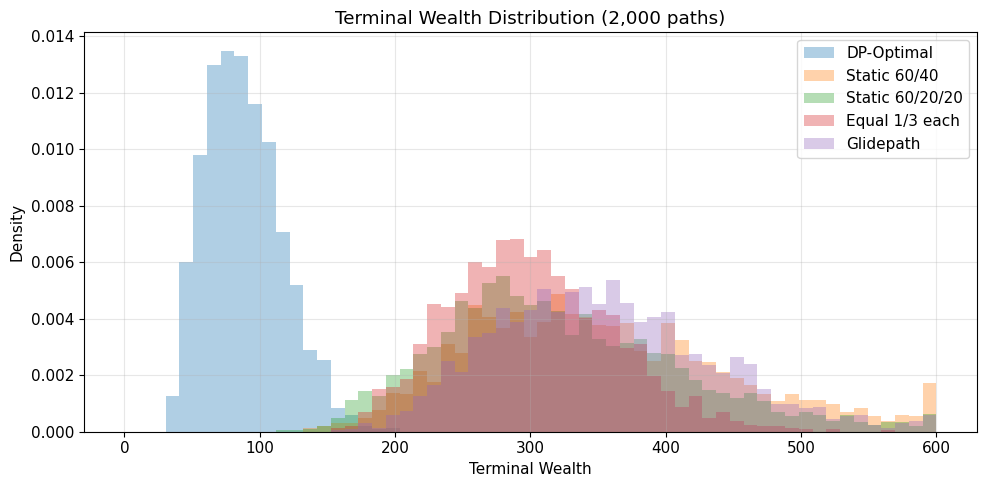

Terminal Wealth Statistics
Strategy               Mean   Median      Std     5th%    95th%
--------------------------------------------------------------
DP-Optimal             88.5     85.9     28.1     47.9    140.6
Static 60/40          351.2    339.6     96.3    213.9    534.9
Static 60/20/20       321.9    309.2     89.0    194.5    488.1
Equal 1/3 each        300.7    296.2     60.9    208.5    405.7
Glidepath             354.1    347.2     80.8    234.4    498.5

Total Discounted Utility  Σ β^t·u(cₜ) + β^T·u(W_T)
Strategy                 Mean     Median       5th%
----------------------------------------------------
DP-Optimal            -0.9522    -0.9328    -1.2237
Static 60/40          -2.2261    -2.1917    -2.8186
Static 60/20/20       -2.3077    -2.2604    -2.8855
Equal 1/3 each        -2.3511    -2.3212    -2.8692
Glidepath             -2.2197    -2.1740    -2.8187


In [8]:
# Terminal wealth distributions
fig, ax = plt.subplots(figsize=(10, 5))
bins = np.linspace(0, W_MAX, 60)
for name, w, a, c, u in results:
    ax.hist(w[:, -1], bins=bins, alpha=0.35, label=name, density=True)
ax.set_xlabel("Terminal Wealth")
ax.set_ylabel("Density")
ax.set_title(f"Terminal Wealth Distribution ({N_SIM:,} paths)")
ax.legend()
plt.tight_layout()
plt.show()

# Summary statistics
print("Terminal Wealth Statistics")
print(f"{'Strategy':<18} {'Mean':>8} {'Median':>8} {'Std':>8} {'5th%':>8} {'95th%':>8}")
print("-" * 62)
for name, w, a, c, u in results:
    tw = w[:, -1]
    print(f"{name:<18} {tw.mean():>8.1f} {np.median(tw):>8.1f} {tw.std():>8.1f} "
          f"{np.percentile(tw, 5):>8.1f} {np.percentile(tw, 95):>8.1f}")

print(f"\nTotal Discounted Utility  Σ β^t·u(cₜ) + β^T·u(W_T)")
print(f"{'Strategy':<18} {'Mean':>10} {'Median':>10} {'5th%':>10}")
print("-" * 52)
for name, w, a, c, u in results:
    print(f"{name:<18} {u.mean():>10.4f} {np.median(u):>10.4f} {np.percentile(u, 5):>10.4f}")

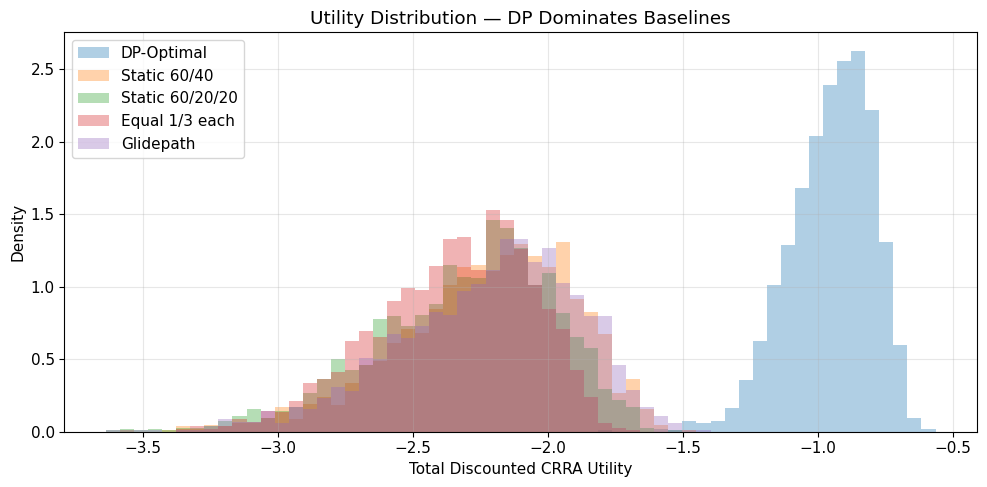

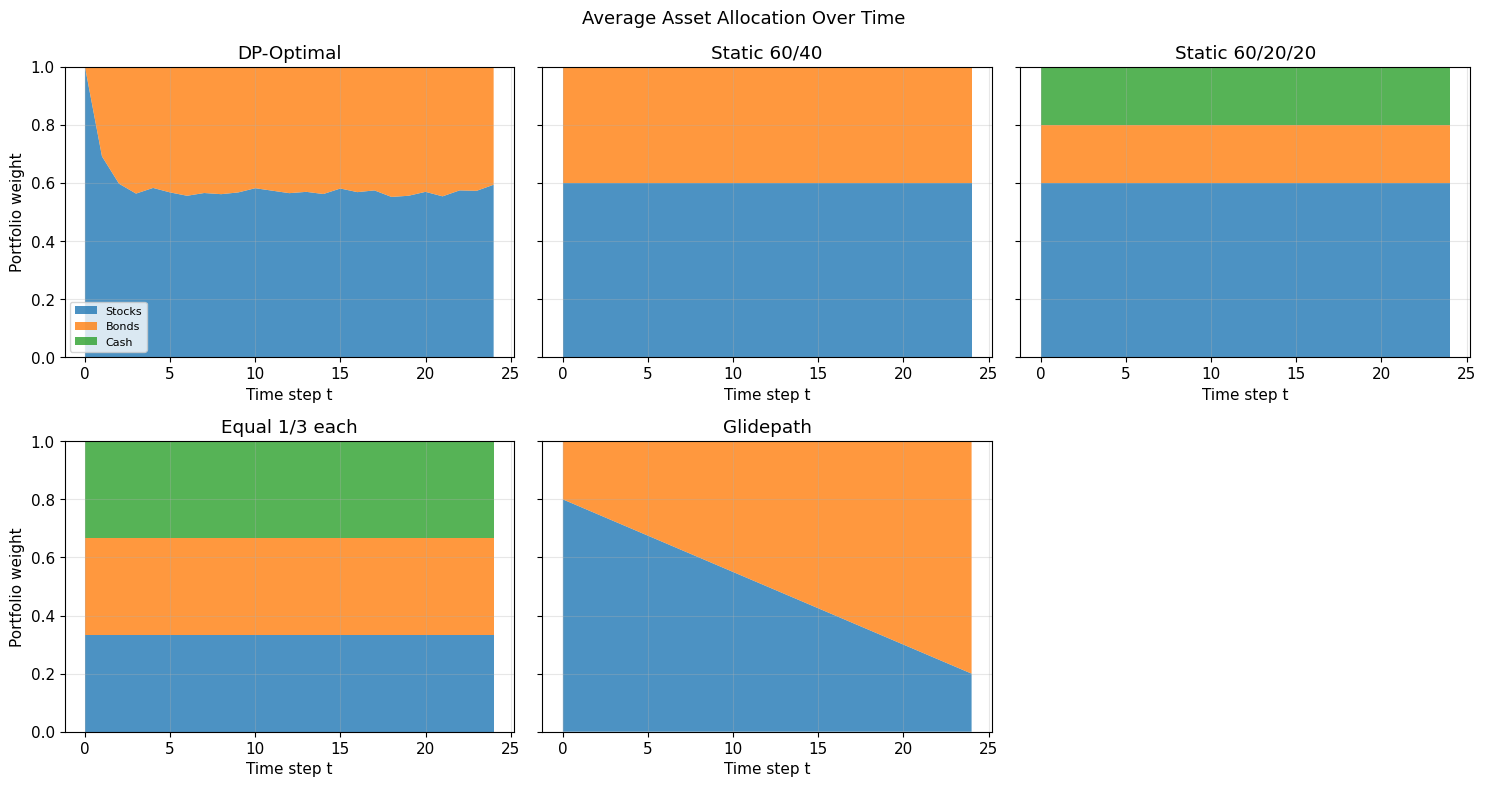

In [9]:
# Total discounted utility distributions
fig, ax = plt.subplots(figsize=(10, 5))
all_utils = np.concatenate([u for _, _, _, _, u in results])
u_bins = np.linspace(max(all_utils.min(), -8), all_utils.max(), 60)
for name, w, a, c, u in results:
    ax.hist(u, bins=u_bins, alpha=0.35, label=name, density=True)
ax.set_xlabel("Total Discounted CRRA Utility")
ax.set_ylabel("Density")
ax.set_title("Utility Distribution — DP Dominates Baselines")
ax.legend()
plt.tight_layout()
plt.show()

# Average allocation over time for each strategy
asset_names = ["Stocks", "Bonds", "Cash"]
alloc_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ncol = 3
nrow = (len(results) + ncol - 1) // ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(5 * ncol, 4 * nrow), sharey=True)
axes_flat = axes.flatten()

for idx, (name, w, allocs, c, u) in enumerate(results):
    ax = axes_flat[idx]
    mean_alloc = allocs.mean(axis=0)
    ax.stackplot(range(T), mean_alloc.T, labels=asset_names, colors=alloc_colors, alpha=0.8)
    ax.set_title(name)
    ax.set_xlabel("Time step t")
    ax.set_ylim(0, 1)

for idx in range(len(results), nrow * ncol):
    axes_flat[idx].set_visible(False)

axes_flat[0].set_ylabel("Portfolio weight")
if nrow > 1:
    axes_flat[ncol].set_ylabel("Portfolio weight")
axes_flat[0].legend(loc="lower left", fontsize=8)
fig.suptitle("Average Asset Allocation Over Time", fontsize=13)
plt.tight_layout()
plt.show()

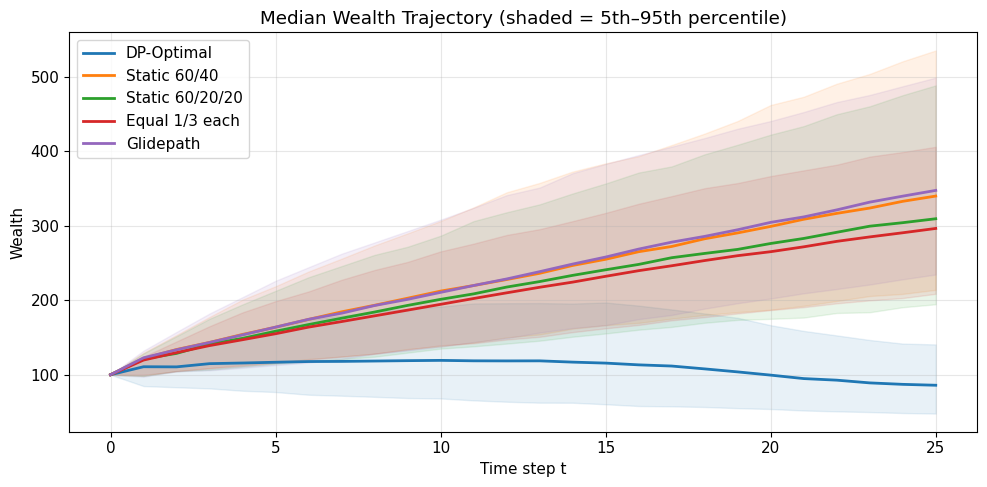

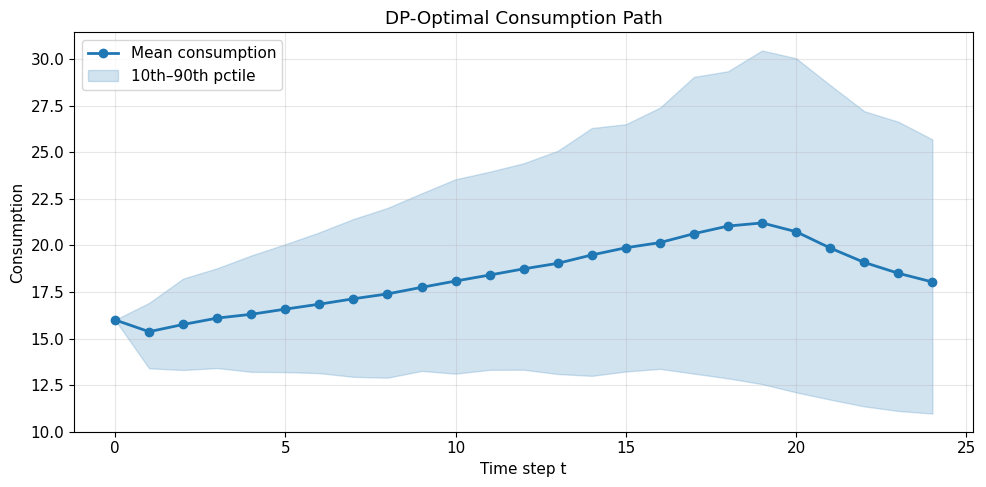

In [10]:
# Median wealth trajectory with 5th–95th percentile bands
fig, ax = plt.subplots(figsize=(10, 5))
ts = np.arange(T + 1)
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

for (name, w, a, c, u), color in zip(results, palette):
    med = np.median(w, axis=0)
    p5  = np.percentile(w, 5, axis=0)
    p95 = np.percentile(w, 95, axis=0)
    ax.plot(ts, med, label=name, color=color, linewidth=2)
    ax.fill_between(ts, p5, p95, alpha=0.1, color=color)

ax.set_xlabel("Time step t")
ax.set_ylabel("Wealth")
ax.set_title("Median Wealth Trajectory (shaded = 5th–95th percentile)")
ax.legend()
plt.tight_layout()
plt.show()

# DP-Optimal consumption path with percentile bands
dp_cons = results[0][3]
fig, ax = plt.subplots(figsize=(10, 5))
t_axis = np.arange(T)
mean_c = dp_cons.mean(axis=0)
p10_c = np.percentile(dp_cons, 10, axis=0)
p90_c = np.percentile(dp_cons, 90, axis=0)
ax.plot(t_axis, mean_c, "o-", linewidth=2, color="#1f77b4", label="Mean consumption")
ax.fill_between(t_axis, p10_c, p90_c, alpha=0.2, color="#1f77b4", label="10th–90th pctile")
ax.set_xlabel("Time step t")
ax.set_ylabel("Consumption")
ax.set_title("DP-Optimal Consumption Path")
ax.legend()
plt.tight_layout()
plt.show()

## 7. Dimensionality Analysis — Why RL Is Needed for Phase 3

The DP approach works here because the state and action spaces are deliberately small.
Below we compute the exact sizes for Phase 2 and then show how they grow under
Phase 3 parameters (same 3 assets but finer grids, more states, and a longer horizon).

In [11]:
# Phase 2 (current)
states_per_t_p2 = N_WEALTH * N_INCOME * N_REGIME
total_states_p2 = T * states_per_t_p2
actions_per_state_p2 = N_ACTIONS
total_dp_cells_p2 = total_states_p2 * actions_per_state_p2

print("Phase 2 — Simplified DP Problem")
print(f"  Wealth grid         : {N_WEALTH}")
print(f"  Income states       : {N_INCOME}")
print(f"  Regime states       : {N_REGIME}")
print(f"  States per period   : {states_per_t_p2:,}")
print(f"  Total state×time    : {total_states_p2:,}")
print(f"  Allocations         : {N_ALLOC}")
print(f"  Consumption choices : {N_CONS}")
print(f"  Actions per state   : {actions_per_state_p2}")
print(f"  Total DP cells      : {total_dp_cells_p2:,}")
print()

# Phase 3 (RL version) — same 3 assets, finer grids & more states
n_assets_p3 = 3
increments_p3 = 10  # 10% granularity ⇒ 10 slots to fill among 3 assets
n_alloc_p3 = int(comb(increments_p3 + n_assets_p3 - 1, n_assets_p3 - 1, exact=True))

n_cons_p3 = 20       # finer consumption grid
n_wealth_p3 = 500    # finer wealth grid
n_income_p3 = 3      # low / medium / high
n_regime_p3 = 3      # bear / normal / bull
T_p3 = 40            # longer horizon

states_per_t_p3 = n_wealth_p3 * n_income_p3 * n_regime_p3
total_states_p3 = T_p3 * states_per_t_p3
actions_per_state_p3 = n_cons_p3 * n_alloc_p3
total_dp_cells_p3 = total_states_p3 * actions_per_state_p3

print("Phase 3 — RL Problem (3 assets, 10% increments)")
print(f"  Assets              : {n_assets_p3} (stocks, bonds, cash)")
print(f"  Wealth grid         : {n_wealth_p3}")
print(f"  Income states       : {n_income_p3}")
print(f"  Regime states       : {n_regime_p3}")
print(f"  States per period   : {states_per_t_p3:,}")
print(f"  Total state×time    : {total_states_p3:,}")
print(f"  Allocations C({increments_p3+n_assets_p3-1},{n_assets_p3-1}): {n_alloc_p3:,}")
print(f"  Consumption choices : {n_cons_p3}")
print(f"  Actions per state   : {actions_per_state_p3:,}")
print(f"  Total DP cells      : {total_dp_cells_p3:,}")
print()

ratio = total_dp_cells_p3 / total_dp_cells_p2
print(f"Blowup factor (Phase 3 / Phase 2): {ratio:,.0f}×")
print(f"\n→ Even with the same 3 assets, finer grids and more states make exact DP")
print(f"  impractical; function-approximation RL is required.")

Phase 2 — Simplified DP Problem
  Wealth grid         : 121
  Income states       : 2
  Regime states       : 2
  States per period   : 484
  Total state×time    : 12,100
  Allocations         : 15
  Consumption choices : 11
  Actions per state   : 165
  Total DP cells      : 1,996,500

Phase 3 — RL Problem (3 assets, 10% increments)
  Assets              : 3 (stocks, bonds, cash)
  Wealth grid         : 500
  Income states       : 3
  Regime states       : 3
  States per period   : 4,500
  Total state×time    : 180,000
  Allocations C(12,2): 66
  Consumption choices : 20
  Actions per state   : 1,320
  Total DP cells      : 237,600,000

Blowup factor (Phase 3 / Phase 2): 119×

→ Even with the same 3 assets, finer grids and more states make exact DP
  impractical; function-approximation RL is required.


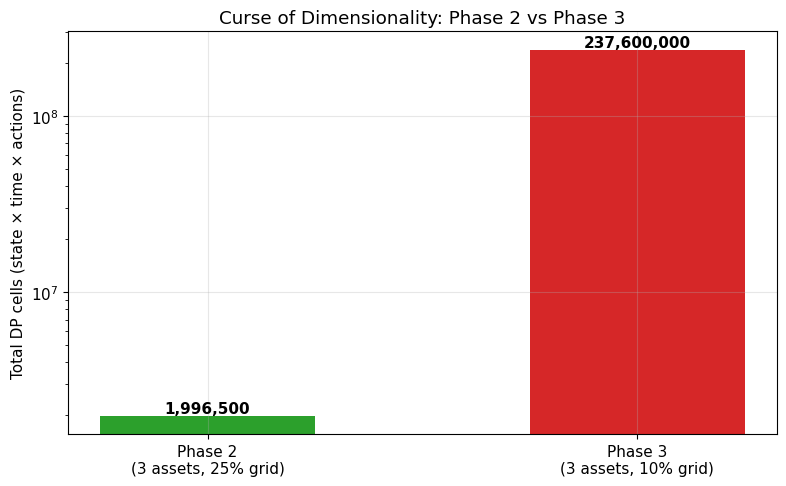

In [12]:
# Visual: bar chart comparing state × action counts
fig, ax = plt.subplots(figsize=(8, 5))
labels = ["Phase 2\n(3 assets, 25% grid)", "Phase 3\n(3 assets, 10% grid)"]
values = [total_dp_cells_p2, total_dp_cells_p3]
bars = ax.bar(labels, values, color=["#2ca02c", "#d62728"], width=0.5)
ax.set_ylabel("Total DP cells (state × time × actions)")
ax.set_title("Curse of Dimensionality: Phase 2 vs Phase 3")
ax.set_yscale("log")
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f"{val:,.0f}", ha="center", va="bottom", fontweight="bold")
plt.tight_layout()
plt.show()